### 1. install the CUDA toolkit
sudo apt update
sudo apt install nvidia-cuda-toolkit
### 2. Verify nvcc and locate libdevice
which nvcc # should print something like /usr/local/cuda/bin/nvcc or /usr/bin/nvcc
nvcc --version # should list “release 12.4” (or whatever you installed)
ls /usr/local/cuda/nvvm/libdevice # check that XLA can find libdevice files
### 2.1 look for where the file is
sudo find /usr -type f -name 'libdevice*.bc' OR dpkg -L nvidia-cuda-toolkit | grep libdevice
### 3. point XLA at the correct dir
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda/nvvm/libdevice"
### 4. test from python
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

In [ ]:
#import os
#os.environ['XLA_FLAGS'] = (
#    '--xla_gpu_cuda_data_dir=/usr/lib/cuda/nvvm/libdevice'
#)


In [ ]:
#import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))

2025-07-08 10:20:51.982506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751988052.268167  312522 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751988052.351246  312522 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751988053.044904  312522 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751988053.044977  312522 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751988053.044989  312522 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from scipy.stats import pearsonr


from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



/home/emine2/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-07-08 10:22:07.389993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751988127.412468  313453 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751988127.419209  313453 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751988127.437061  313453 computation_placer.cc:17

In [4]:
#ins = pd.read_csv('/home/emine2/CPSC-499/data/insurance_with_weather.csv')
ins = pd.read_csv('/home/emine2/CPSC-499/data/insurance_with_weather_cleaned.csv')
ins

,commodity_year_identifier,state_abbreviation,county_code,county_name,commodity_code,cause_of_loss_code,cause_of_loss_description,month_of_loss,policies_indemnified,net_planted_quantity,...,subsidy,state/private_subsidy,additional_subsidy,efa_premium_discount,net_determined_quantity,indemnity_amount,loss_ratio,county_fips,total_precipitation_m,temperature_K
0,2016,IL,1,Adams,41,11,drought,8,1,68.000000,...,1767.0,0.0,0.0,0.0,68.0000,5723.0,1.78,17001,0.002598,298.068945
1,2016,IL,1,Adams,41,11,drought,11,1,28.900000,...,733.0,0.0,0.0,0.0,28.9000,3409.0,1.77,17001,0.001104,282.686963
2,2016,IL,1,Adams,41,11,drought,6,2,63.550000,...,1506.5,0.0,0.0,0.0,71.2000,2362.0,0.67,17001,0.004493,299.282715
3,2016,IL,1,Adams,41,11,drought,6,1,13.550000,...,261.5,0.0,0.0,0.0,5.9000,338.0,0.49,17001,0.004493,299.282715
4,2016,IL,1,Adams,41,11,drought,10,1,56.400000,...,1079.0,0.0,0.0,0.0,56.4000,14447.0,5.09,17001,0.001843,289.454004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51378,2024,IL,203,Woodford,81,31,excess-moisture,5,1,210.630000,...,500.0,0.0,0.0,0.0,93.0000,3222.0,2.45,17203,0.003036,292.451823
51379,2024,IL,203,Woodford,81,31,excess-moisture,10,1,11.090551,...,35.5,0.0,0.0,0.0,22.1811,333.0,3.56,17203,0.004033,288.004150
51380,2024,IL,203,Woodford,81,31,excess-moisture,6,1,82.501497,...,263.5,0.0,0.0,0.0,51.6770,1790.0,2.58,17203,0.004996,297.068034
51381,2024,IL,203,Woodford,81,31,excess-moisture,6,6,913.720000,...,10907.0,0.0,0.0,0.0,264.4700,12489.0,0.59,17203,0.004996,297.068034


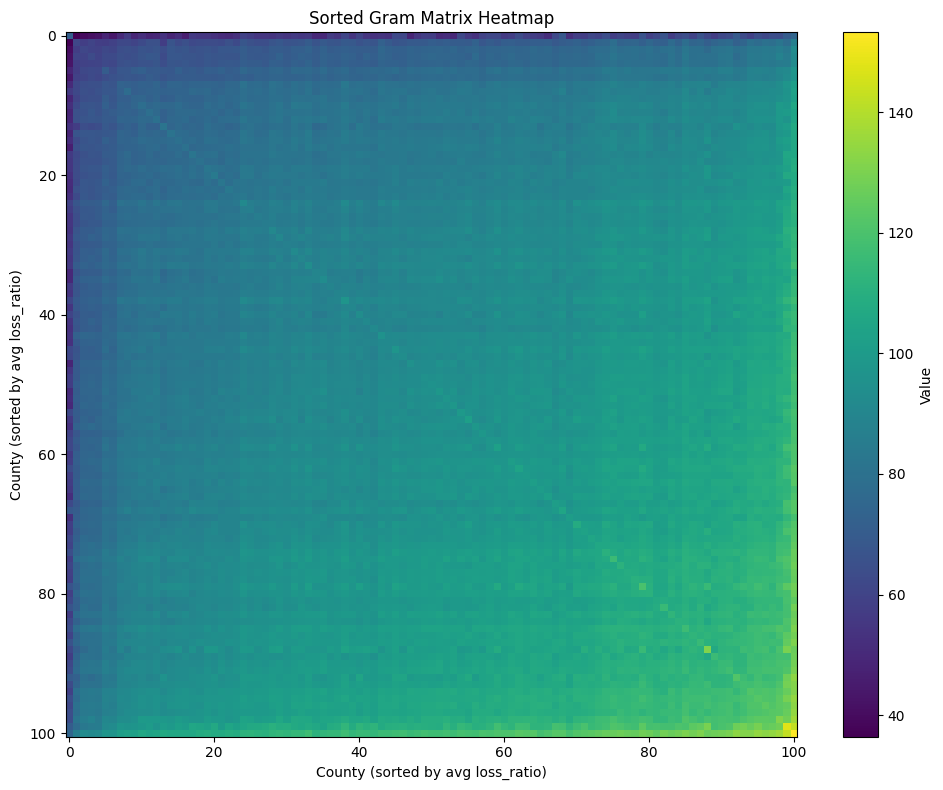

county_fips,17069,17041,17115,17139,17029,17153,17021,17019,17147,17059,...,17121,17143,17123,17133,17169,17081,17149,17109,17155,17125
county_fips,,,,,,,,,,,,,,,,,,,,,
17069,71.983051,36.438456,40.352409,41.820538,43.205413,48.324380,44.008224,50.559750,56.721706,49.084602,...,63.748835,69.941409,62.963619,58.959537,64.591774,61.871951,64.317680,64.170493,70.394059,74.530031
17041,36.438456,61.320779,58.191772,60.203829,57.925599,57.686435,59.038181,61.934899,61.780390,60.438149,...,77.134195,72.865732,74.664385,79.359417,77.688798,79.892837,78.899429,81.745574,78.407332,86.916404
17115,40.352409,58.191772,61.156033,60.099899,59.517868,61.824450,61.030402,64.560083,64.946451,64.661993,...,82.225656,79.375183,80.262017,83.225278,83.378561,84.533065,83.738560,86.007510,83.362383,92.731639
17139,41.820538,60.203829,60.099899,63.198993,59.863935,62.668978,62.758581,64.770626,64.691117,65.060510,...,82.600075,77.709975,80.302623,84.562597,83.511541,84.925649,84.549649,88.287758,85.111870,91.834156
17029,43.205413,57.925599,59.517868,59.863935,60.496606,62.272989,61.315138,65.179933,65.686715,65.161711,...,82.601313,80.145450,80.312123,83.779163,83.149908,84.435876,83.333095,85.109483,85.669259,92.571701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,61.871951,79.892837,84.533065,84.925649,84.435876,88.369600,86.748311,91.435665,92.241207,93.754339,...,118.831426,115.140996,117.861804,120.931809,121.027941,123.753923,121.516156,123.978468,125.326197,132.817587
17149,64.317680,78.899429,83.738560,84.549649,83.333095,87.458504,87.575768,91.019400,93.411102,93.474399,...,118.844702,116.046668,117.557789,120.262501,120.418195,121.516156,122.808792,123.172789,125.918269,134.227242
17109,64.170493,81.745574,86.007510,88.287758,85.109483,90.705919,89.731476,93.509747,93.494165,95.118596,...,118.655890,118.055259,120.803918,122.538730,123.769274,123.978468,123.172789,131.563839,127.913370,136.620063


In [5]:
# 1) Pivot
county_loss_matrix = ins.pivot_table(
    index='county_fips',
    columns='commodity_year_identifier',
    values='loss_ratio',
    fill_value=0
)

# 2) Sort counties by their average loss_ratio
county_score     = county_loss_matrix.mean(axis=1)
sorted_counties  = county_score.sort_values(ascending=True).index

# 3) Compute the Gram matrix (counties × counties)
gram = county_loss_matrix.dot(county_loss_matrix.T)

# 4) Reorder the Gram matrix on both axes
gram_sorted = gram.loc[sorted_counties, sorted_counties]

# 5) Plot
plt.figure(figsize=(10,8))
plt.imshow(gram_sorted.values, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Sorted Gram Matrix Heatmap')
plt.xlabel('County (sorted by avg loss_ratio)')
plt.ylabel('County (sorted by avg loss_ratio)')
plt.tight_layout()
plt.show()
gram_sorted


In [6]:
county_loss_matrix

commodity_year_identifier,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
county_fips,,,,,,,,,,,,,,,,,
17001,3.425077,2.538475,3.651795,2.056296,2.701176,2.913167,2.483462,2.890811,1.577419,2.184889,2.248205,2.815102,2.718182,2.725405,1.323750,2.021562,1.890000
17003,2.783871,2.788095,2.309231,1.621522,1.996923,2.717391,2.220000,2.802250,1.625000,2.159286,1.570000,2.776471,2.532917,1.575769,1.176250,1.663810,2.023043
17005,3.250392,3.130597,2.694516,1.854000,2.760270,2.672333,1.576111,3.056957,1.706111,1.485769,2.040588,3.495000,1.987241,1.864545,1.658889,1.636071,2.514318
17007,2.832800,2.938387,2.181667,2.297500,3.082593,2.021000,3.352857,2.485000,1.361667,2.681389,2.775385,2.103913,2.833636,2.467273,1.108000,2.138333,2.492800
17009,2.936154,2.226400,2.968621,1.571389,3.440435,3.522917,3.057143,2.840588,2.712727,1.266667,1.619000,3.279048,2.390000,2.098235,1.936000,2.017895,2.149545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17195,2.740789,2.501220,2.352083,1.133684,2.603125,3.085455,2.884231,2.687368,1.390000,2.532143,3.345937,2.966522,2.328250,1.995217,0.518000,1.564583,2.126250
17197,2.705476,2.681667,2.653721,2.372826,2.835455,2.754565,2.715556,2.124000,2.084118,2.181724,3.049286,3.363333,2.668000,2.666000,1.225000,2.657200,2.413333
17199,3.130455,2.562187,1.549310,1.296000,3.878261,2.359091,2.231379,2.336923,2.544815,1.782353,1.718333,2.450000,2.031818,2.084737,1.221000,2.304545,2.276786


In [7]:
# --- 2) Spectral embedding on the Gram (2 dimensions) ---
embedder = SpectralEmbedding(n_components=2, affinity='precomputed')
emb = embedder.fit_transform(gram.values)
embed_df = (
    pd.DataFrame(emb, index=gram.index, columns=['dim1','dim2'])
      .reset_index()
      .rename(columns={'index':'county_fips'})
)
embed_df

,county_fips,dim1,dim2
0,17001,-0.000748,0.000545
1,17003,-0.000655,0.001518
2,17005,-0.001612,0.001055
3,17007,0.000525,-0.000355
4,17009,-0.000101,0.000952
...,...,...,...
96,17195,0.000796,0.000680
97,17197,0.000014,-0.000847
98,17199,0.000053,0.000001
99,17201,0.001173,-0.001210


In [8]:
# --- 3) Load  weather covariates (must have county_fips, avg_temp, avg_precip) ---
weather = ins[['total_precipitation_m', 'temperature_K', 'county_fips']].copy()
weather.rename(columns={'total_precipitation_m': 'avg_precip', 'temperature_K': 'avg_temp'}, inplace=True)
# --- 3) Load  weather covariates (must have county_fips, avg_temp, avg_precip) ---
weather = ins[['total_precipitation_m', 'temperature_K', 'county_fips']].copy()
weather.rename(columns={'total_precipitation_m': 'avg_precip', 'temperature_K': 'avg_temp'}, inplace=True)
weather = weather.groupby('county_fips', as_index=False).mean()
weather = weather.fillna(weather.mean())
weather


,county_fips,avg_precip,avg_temp
0,17001,0.002984,291.893190
1,17003,0.003078,292.142004
2,17005,0.003147,293.310634
3,17007,0.002687,288.981908
4,17009,0.003296,292.582726
...,...,...,...
96,17195,0.003031,289.898695
97,17197,0.003000,290.122646
98,17199,0.003191,296.196719
99,17201,0.002675,289.359501


Corr(avg_temp, dim1) = -0.269, p‐value = 0.00653
Corr(avg_precip, dim1) = -0.317, p‐value = 0.00124
Corr(avg_temp, dim2) = 0.249, p‐value = 0.0119
Corr(avg_precip, dim2) = 0.167, p‐value = 0.0944

Per‐cluster weather summary:
           avg_temp                 avg_precip                
               mean       std count       mean       std count
cluster                                                       
0        291.248686  1.730627    46   0.003023  0.000173    46
1        292.902978  1.828819    54   0.003125  0.000107    54
2        292.142004       NaN     1   0.003078       NaN     1


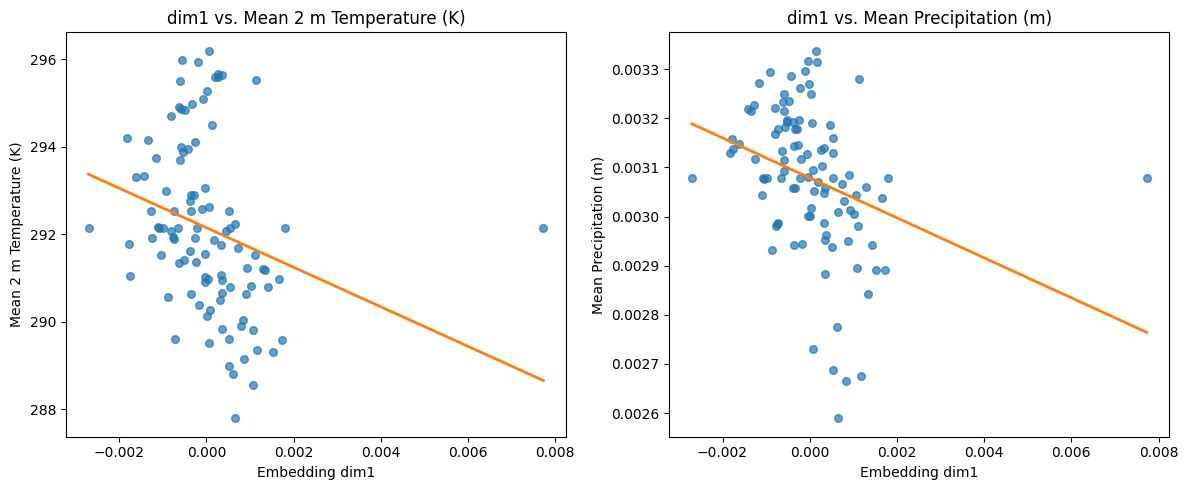

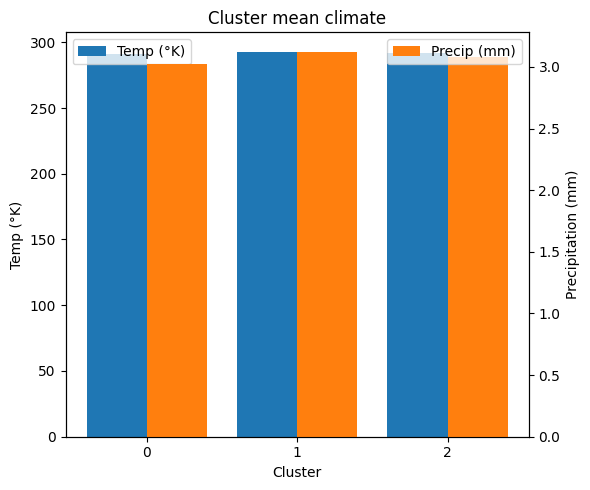

In [9]:
# --- 4) Merge and compute correlations ---
merged = embed_df.merge(weather, on='county_fips')

# Pearson r between each embedding dim and each covariate
for dim in ['dim1','dim2']:
    for cov in ['avg_temp','avg_precip']:
        r, p = pearsonr(merged[dim], merged[cov])
        print(f"Corr({cov}, {dim}) = {r:.3f}, p‐value = {p:.3g}")

# --- 5) K-Means clustering on the embedding ---
kmeans = KMeans(n_clusters=3, random_state=0).fit(emb)
cluster_df = (
    pd.DataFrame({
        'county_fips': gram.index,
        'cluster': kmeans.labels_
    })
)

# Merge clusters with weather and report cluster means
clustered = cluster_df.merge(weather, on='county_fips')
cluster_stats = clustered.groupby('cluster')[['avg_temp','avg_precip']].agg(['mean','std','count'])
print("\nPer‐cluster weather summary:")
print(cluster_stats)
clustered
# --- 6) Visualizations ---
# 1) Scatter plots with regression line
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, covar, ylabel in zip(
    axes,
    ["avg_temp", "avg_precip"],
    ["Mean 2 m Temperature (K)", "Mean Precipitation (m)"]
):
    x = merged["dim1"]
    y = merged[covar]
    # scatter
    ax.scatter(x, y, s=30, alpha=0.7)
    # line‐of‐best‐fit
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, m*xs + b, color="C1", lw=2)
    ax.set_xlabel("Embedding dim1")
    ax.set_ylabel(ylabel)
    ax.set_title(f"dim1 vs. {ylabel}")

plt.tight_layout()
plt.show()

# 2) Cluster bar‐charts
# Compute cluster means
cluster_means = (
    clustered.groupby("cluster")[["avg_temp","avg_precip"]]
             .mean()
             .reset_index()
)

fig, ax1 = plt.subplots(figsize=(6,5))
ind = cluster_means["cluster"].astype(int)

# Bar for temperature (left axis)
ax1.bar(ind - 0.2, cluster_means["avg_temp"], width=0.4, label="Temp (°K)")
ax1.set_ylabel("Temp (°K)")
ax1.set_xlabel("Cluster")
ax1.set_xticks(ind)
ax1.set_title("Cluster mean climate")
ax1.legend(loc="upper left")

# Twin axis for precipitation
ax2 = ax1.twinx()
ax2.bar(ind + 0.2, cluster_means["avg_precip"]*1000, width=0.4, color="C1", label="Precip (mm)")
ax2.set_ylabel("Precipitation (mm)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [10]:
# --- 0) have:
#    county_loss_matrix: DataFrame (county_fips × loss‐features)
#    gram_loss          : DataFrame (county_fips × county_fips) = loss @ loss.T
#    weather: DataFrame with columns ['county_fips','avg_temp','avg_precip']

# --- 1) Align counties
common = county_loss_matrix.index.intersection(weather['county_fips'])
X_loss = county_loss_matrix.loc[common].values         # (n_counties × n_years)
weather_sub = weather.set_index('county_fips').loc[common]
X_weather = weather_sub[['avg_temp','avg_precip']].values  # (n_counties × 2)

# --- 2) Standardize weather, then stack
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

# Final feature matrix
X_combined = np.hstack([X_loss, X_weather_scaled])  
# Compute new Gram
K = X_combined @ X_combined.T          # shape: (n_counties × n_counties)

# --- 3) Prepare target: long‐term mean loss
y = county_loss_matrix.mean(axis=1).loc[common].values

# --- 4) Train/test split on the indices
idx = np.arange(len(common))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=0)

K_train = K[np.ix_(train_idx, train_idx)]
K_test  = K[np.ix_(test_idx,  train_idx)]
y_train = y[train_idx]
y_test  = y[test_idx]

# --- 5) SVR with combined kernel
svr = SVR(kernel="precomputed", C=1.0, epsilon=0.1)
svr.fit(K_train, y_train)
y_pred_svr = svr.predict(K_test)
print("SVR+weather RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))

# --- 6) GPR on the augmented features
X_train = X_combined[train_idx]
X_test  = X_combined[test_idx]

kernel = DotProduct()**2 + WhiteKernel(noise_level=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr.fit(X_train, y_train)
y_pred_gpr, y_std = gpr.predict(X_test, return_std=True)
print("GPR+weather RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gpr)))

# --- 7) Compare
results = pd.DataFrame({
    'county_fips': common[test_idx],
    'y_true':      y_test,
    'svr+weather': y_pred_svr,
    'gpr+weather': y_pred_gpr,
    'gpr_std':     y_std
})
print(results.head())
results


SVR+weather RMSE: 0.10025048158168277
GPR+weather RMSE: 0.3048395589193467
   county_fips    y_true  svr+weather  gpr+weather   gpr_std
0        17055  2.241470     2.285524     2.286536  0.604081
1        17175  2.134531     2.181749     2.218921  1.027058
2        17005  2.316689     2.298792     2.334789  0.461585
3        17113  2.111693     2.141125     2.155634  0.740069
4        17153  1.883051     2.010948     1.896722  1.177689


/home/emine2/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,county_fips,y_true,svr+weather,gpr+weather,gpr_std
0,17055,2.241470,2.285524,2.286536,0.604081
1,17175,2.134531,2.181749,2.218921,1.027058
2,17005,2.316689,2.298792,2.334789,0.461585
3,17113,2.111693,2.141125,2.155634,0.740069
4,17153,1.883051,2.010948,1.896722,1.177689
5,17191,2.278497,2.290909,2.272529,0.414350
6,17033,2.299100,2.308090,2.277844,0.433626
7,17149,2.651369,2.562216,2.571892,0.450660
8,17111,2.493906,2.452530,2.710601,2.253859
9,17195,2.279698,2.294869,2.303285,0.934156


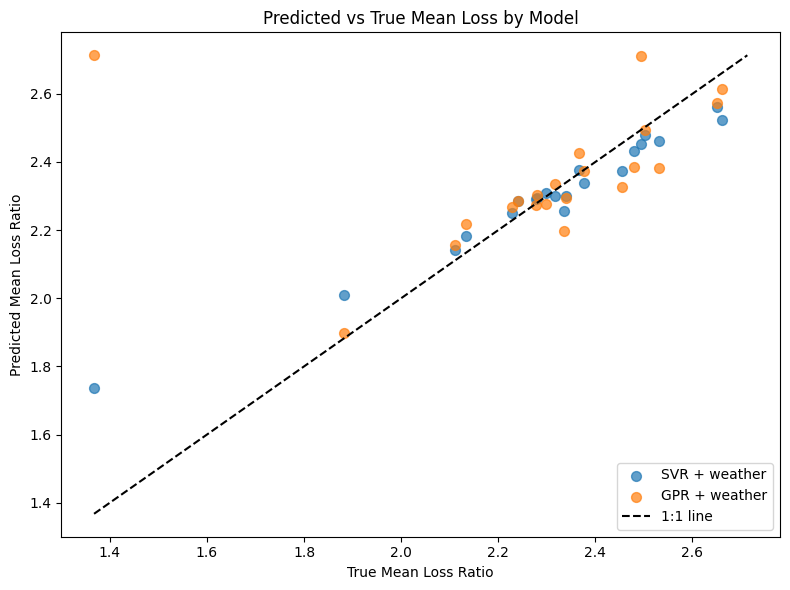

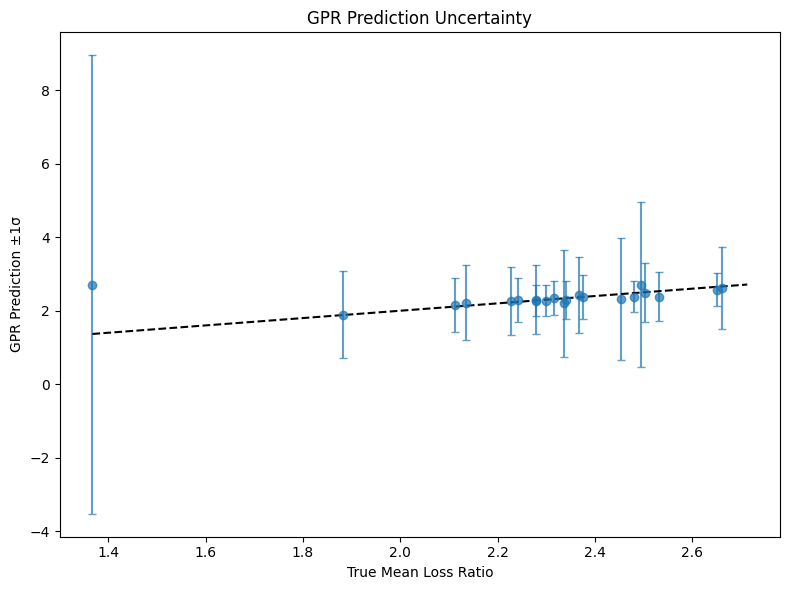

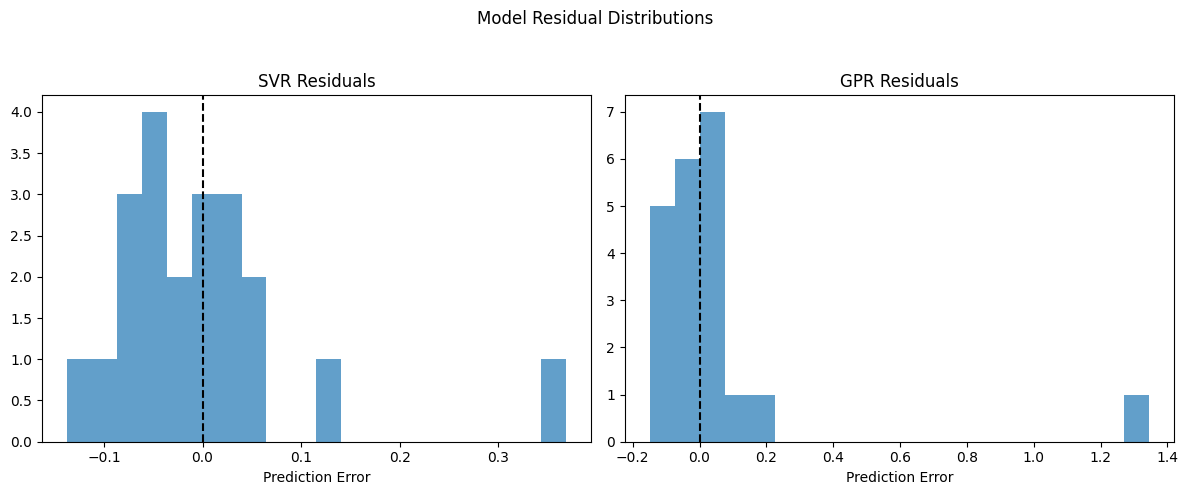

In [11]:

# ── 1) Scatter: True vs. Predicted ─────────────────────────────────────────
plt.figure(figsize=(8,6))
plt.scatter(results['y_true'], results['svr+weather'],
            label='SVR + weather', alpha=0.7, s=50)
plt.scatter(results['y_true'], results['gpr+weather'],
            label='GPR + weather', alpha=0.7, s=50)

# 1:1 reference line:
lo = min(results[['y_true','svr+weather','gpr+weather']].min())
hi = max(results[['y_true','svr+weather','gpr+weather']].max())
plt.plot([lo, hi], [lo, hi], 'k--', label='1:1 line')

plt.xlabel('True Mean Loss Ratio')
plt.ylabel('Predicted Mean Loss Ratio')
plt.title('Predicted vs True Mean Loss by Model')
plt.legend()
plt.tight_layout()
plt.show()

# ── 2) GPR Predictions with Uncertainty ──────────────────────────────────
plt.figure(figsize=(8,6))
plt.errorbar(
    results['y_true'], results['gpr+weather'],
    yerr=results['gpr_std'], fmt='o', alpha=0.7, capsize=3
)
plt.plot([lo, hi], [lo, hi], 'k--')
plt.xlabel('True Mean Loss Ratio')
plt.ylabel('GPR Prediction ±1σ')
plt.title('GPR Prediction Uncertainty')
plt.tight_layout()
plt.show()

# ── 3) Residual Histograms ───────────────────────────────────────────────
res_svr = results['svr+weather'] - results['y_true']
res_gpr = results['gpr+weather'] - results['y_true']

fig, axs = plt.subplots(1, 2, figsize=(12,5))
bins = 20

axs[0].hist(res_svr, bins=bins, alpha=0.7)
axs[0].axvline(0, color='k', linestyle='--')
axs[0].set_title('SVR Residuals')
axs[0].set_xlabel('Prediction Error')

axs[1].hist(res_gpr, bins=bins, alpha=0.7)
axs[1].axvline(0, color='k', linestyle='--')
axs[1].set_title('GPR Residuals')
axs[1].set_xlabel('Prediction Error')

plt.suptitle('Model Residual Distributions')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# Keras example of an autoencoder style network
1. Encodes the county loss history and climate into a single latent node to train to match the observed mean loss
2. decodes that latent (the predicted loss) back into the cliamte variables. 



In [19]:
# 1a) align counties present in both tables
common = county_loss_matrix.index.intersection(weather['county_fips'])
X_loss = county_loss_matrix.loc[common].values                 # shape (n_counties, n_years)
weather_sub = weather.set_index('county_fips').loc[common]
X_weather = weather_sub[['avg_temp','avg_precip']].values        # shape (n_counties, 2)

# 1b) standardize weather so that temp & precip live on the same scale
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

# 1c) build the combined feature matrix
X_combined = np.hstack([X_loss, X_weather_scaled])              # shape (n_counties, n_years+2)

# 1d) targets:
y_loss    = county_loss_matrix.mean(axis=1).loc[common].values  # one number per county
y_climate = X_weather                                           # the true climate (un-scaled)


# 2. Define the encoder-decoder model

I got an error about the model trying to use GPU, but cant find a compatible CUDA directory. So I can just;
1. Force training on the CPU
or
2. Point XLA at a valid CUDA install

In [33]:
n_years     = X_loss.shape[1]
climate_dim = X_weather.shape[1]  # =2

# — Encoder: (loss history + climate) → bottleneck of size 1
inp = Input(shape=(n_years + climate_dim,), name="combined_input")
x   = Dense(128, activation="relu")(inp)
x   = Dense(64,  activation="relu")(x)
latent = Dense(1, activation="linear", name="latent_loss")(x)
#    this single neuron is the predicted loss

# — Decoder: latent_loss → reconstructed climate
d = Dense(32, activation="relu", name="decoder_dense1")(latent)
d = Dense(16, activation="relu", name="decoder_dense2")(d)
climate_out = Dense(climate_dim, activation="linear", name="predicted_climate")(d)

# — Build & compile multi-output model
autoencoder = Model(inputs=inp, outputs=[latent, climate_out], name="loss_climate_autoencoder")
autoencoder.compile(
    optimizer=Adam(1e-3),
    loss={
      "latent_loss":       "mse",   # match the true average loss
      "predicted_climate": "mse"    # match the true climate vars
    },
    loss_weights={"latent_loss": 1.0, "predicted_climate": 1.0}
)

# 3. Train


In [34]:
# hold out 20% for validation
X_train, X_val, yL_train, yL_val, yC_train, yC_val = train_test_split(
    X_combined, y_loss, y_climate,
    test_size=0.2,
    random_state=42
)

history = autoencoder.fit(
    X_train,
    {"latent_loss":       yL_train,
     "predicted_climate": yC_train},
    validation_data=(
      X_val,
      {"latent_loss":       yL_val,
       "predicted_climate": yC_val}
    ),
    epochs=60, # it was 100, and we plot the reconstruction error, 60 looks good
    batch_size=32
)


Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - latent_loss_loss: 24.5773 - loss: 42385.8750 - predicted_climate_loss: 42339.8320 - val_latent_loss_loss: 40.0599 - val_loss: 42221.7773 - val_predicted_climate_loss: 42181.7188
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - latent_loss_loss: 42.1700 - loss: 42086.1445 - predicted_climate_loss: 42050.9766 - val_latent_loss_loss: 62.7833 - val_loss: 41970.9023 - val_predicted_climate_loss: 41908.1172
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - latent_loss_loss: 65.2637 - loss: 41858.3750 - predicted_climate_loss: 41797.2383 - val_latent_loss_loss: 92.9637 - val_loss: 41678.7500 - val_predicted_climate_loss: 41585.7852
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - latent_loss_loss: 95.6497 - loss: 41591.4883 - predicted_climate_loss: 41481.2188 - val_latent_loss_loss: 133.8583 - val_loss: 41327.9180 - val_predicted_climate_loss: 41194.0586
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - latent_loss_loss: 137.1587 - lo

# 4. Extract a standalone decoder
After training, invert a loss value back into climate via the decoder sub-network

In [35]:
from tensorflow.keras.layers import Input as KInput
from tensorflow.keras.models import Model as KModel

# 4a) create a new Input for just the latent (predicted loss)
latent_input = KInput(shape=(1,), name="latent_input")

# 4b) re‐apply the decoder layers by name
d1 = autoencoder.get_layer("decoder_dense1")(latent_input)
d2 = autoencoder.get_layer("decoder_dense2")(d1)
climate_pred = autoencoder.get_layer("predicted_climate")(d2)

decoder = KModel(inputs=latent_input, outputs=climate_pred, name="decoder")


# 5. Predict and invert

In [36]:
# 5a) predict (loss, climate) from your test set
y_pred_loss, y_pred_climate = autoencoder.predict(X_val)

# 5b) now invert *just* the loss back into climate
climate_from_loss = decoder.predict(y_pred_loss.reshape(-1, 1))

# compare
df = pd.DataFrame({
    "true_temp":      yC_val[:,0],
    "true_precip":    yC_val[:,1],
    "pred_temp_auto": climate_from_loss[:,0],
    "pred_precip_auto": climate_from_loss[:,1]
})
print(df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
    true_temp  true_precip  pred_temp_auto  pred_precip_auto
0  292.618139     0.003095      259.731323          0.015202
1  290.788836     0.002941      238.461670          0.021862
2  292.536187     0.003177      258.717682          0.015515
3  292.075363     0.003187      259.283997          0.015347
4  289.299134     0.002891      265.688812          0.013335


/tmp/ipykernel_313453/2646010572.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axs[0].scatter(df['true_temp'], df['pred_temp_auto'],
/tmp/ipykernel_313453/2646010572.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1].scatter(df['true_precip'], df['pred_precip_auto'],


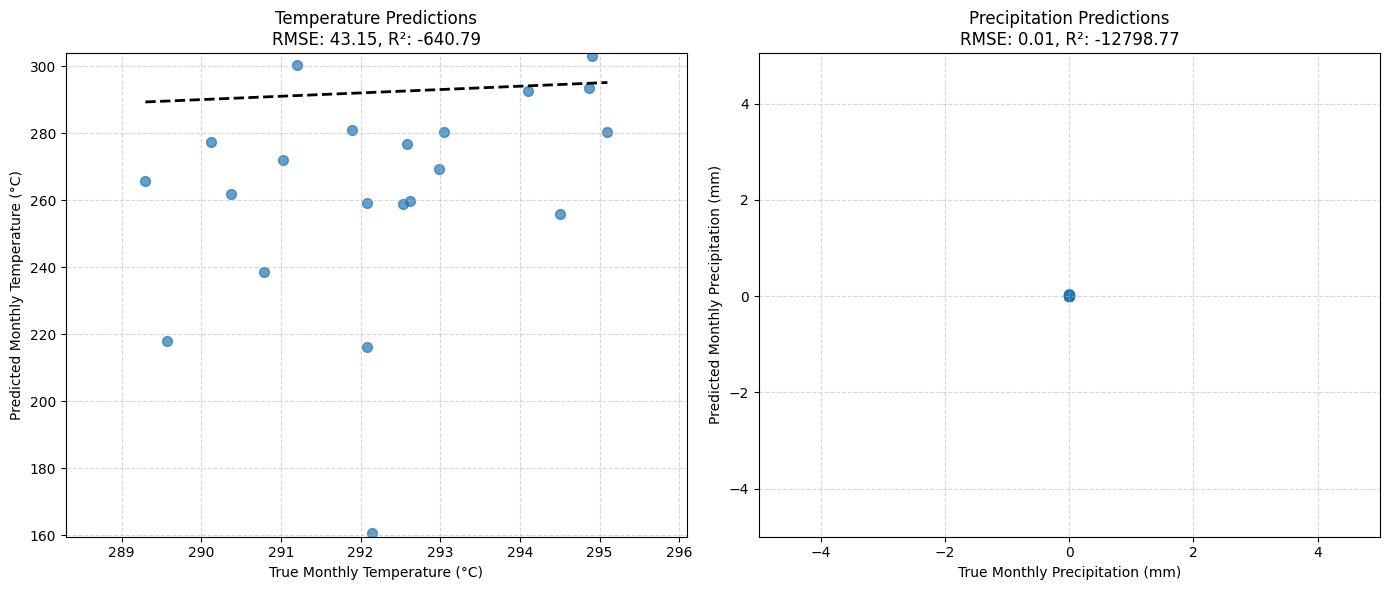

In [37]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Calculate performance metrics
temp_rmse = np.sqrt(mean_squared_error(df['true_temp'], df['pred_temp_auto']))
temp_r2 = r2_score(df['true_temp'], df['pred_temp_auto'])
precip_rmse = np.sqrt(mean_squared_error(df['true_precip'], df['pred_precip_auto']))
precip_r2 = r2_score(df['true_precip'], df['pred_precip_auto'])

# Create scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Temperature plot
scatter = axs[0].scatter(df['true_temp'], df['pred_temp_auto'], 
                        cmap='viridis', alpha=0.7, s=50)
axs[0].plot([df['true_temp'].min(), df['true_temp'].max()],
            [df['true_temp'].min(), df['true_temp'].max()],
            'k--', lw=2)
axs[0].set_xlabel('True Monthly Temperature (°C)')
axs[0].set_ylabel('Predicted Monthly Temperature (°C)')
axs[0].set_title(f'Temperature Predictions\nRMSE: {temp_rmse:.2f}, R²: {temp_r2:.2f}')
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].set_xlim(df['true_temp'].min() - 1, df['true_temp'].max() + 1)
axs[0].set_ylim(df['pred_temp_auto'].min() - 1, df['pred_temp_auto'].max() + 1)

# Precipitation plot
axs[1].scatter(df['true_precip'], df['pred_precip_auto'], 
               cmap='viridis', alpha=0.7, s=50)
axs[1].plot([df['true_precip'].min(), df['true_precip'].max()],
            [df['true_precip'].min(), df['true_precip'].max()],
            'k--', lw=2)
axs[1].set_xlabel('True Monthly Precipitation (mm)')
axs[1].set_ylabel('Predicted Monthly Precipitation (mm)')
axs[1].set_title(f'Precipitation Predictions\nRMSE: {precip_rmse:.2f}, R²: {precip_r2:.2f}')
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].set_xlim(df['true_precip'].min() - 5, df['true_precip'].max() + 5)
axs[1].set_ylim(df['pred_precip_auto'].min() - 5, df['pred_precip_auto'].max() + 5)



# Adjust layout and display
plt.tight_layout()
plt.show()

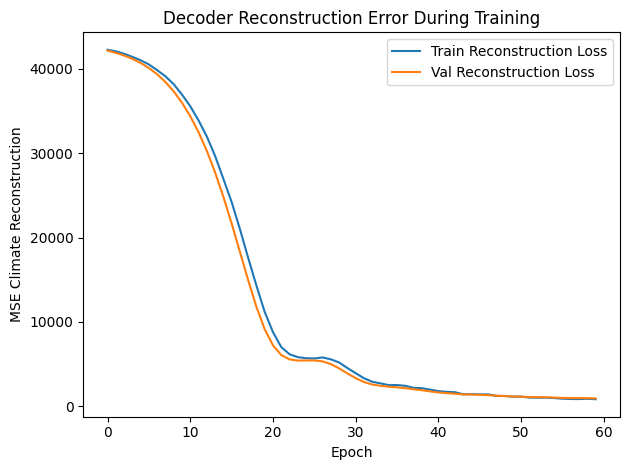

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Final climate reconstruction RMSE (mean ± std): 21.933 ± 21.206

Sample of first 10 reconstructions:
    temp_true  precip_true   temp_pred  precip_pred   temp_err  precip_err
0  292.618139     0.003095  259.731323     0.015202 -32.886816    0.012107
1  290.788836     0.002941  238.461670     0.021862 -52.327166    0.018921
2  292.536187     0.003177  258.717682     0.015515 -33.818505    0.012337
3  292.075363     0.003187  259.283997     0.015347 -32.791367    0.012160
4  289.299134     0.002891  265.688812     0.013335 -23.610322    0.010444
5  294.908717     0.003233  302.868042     0.001679   7.959325   -0.001554
6  294.505345     0.003338  255.761719     0.016435 -38.743626    0.013098
7  290.374759     0.002943  261.920990     0.014503 -28.453769    0.011560
8  292.083446     0.003221  216.071701     0.028885 -76.011745    0.025664
9  291.893190     0.002984  280.787781     0.008604 -11.105409    0.005620


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Plot reconstruction loss over epochs
plt.figure()
plt.plot(history.history['predicted_climate_loss'], label='Train Reconstruction Loss')
plt.plot(history.history['val_predicted_climate_loss'], label='Val Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Climate Reconstruction')
plt.title('Decoder Reconstruction Error During Training')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Compute final reconstruction RMSE on validation set
#    (Assumes X_val and yC_val—the true climate—are in scope)
_, y_pred_climate = autoencoder.predict(X_val)

# Per-sample MSE then RMSE
rec_mse = np.mean((y_pred_climate - yC_val) ** 2, axis=1)
rec_rmse = np.sqrt(rec_mse)

print(f"Final climate reconstruction RMSE (mean ± std): {rec_rmse.mean():.3f} ± {rec_rmse.std():.3f}")

# 3) Optional: inspect a few examples side by side
df_true = pd.DataFrame(yC_val, columns=['temp_true', 'precip_true'])
df_pred = pd.DataFrame(y_pred_climate, columns=['temp_pred', 'precip_pred'])
df_err  = pd.DataFrame({
    'temp_err':   df_pred['temp_pred'] - df_true['temp_true'],
    'precip_err': df_pred['precip_pred'] - df_true['precip_true']
})
df_sample = pd.concat([df_true, df_pred, df_err], axis=1).head(10)
print("\nSample of first 10 reconstructions:")
print(df_sample)
